# Lab: Fine-tuning an Image Model for Weather Classification

As discussed in class, training large computer vision models from scratch takes enormous amounts of data and computational training.  If you don't have days to wait, it is best to **fine tune** a pre-existing well-trained model.  In this lab, we will demonstrate how to fine tune a model for weather classification.  

In going through this lab, you will learn to:

* Download a dataset form **Kagglehub**
* Use operating system python calls to explore files and perform tasks such as splitting the data into training and test
* Download a **base model**.  In this lab, we use the simple MobileNetV2 since it is computationally easy
* **Fine tune** the model with a simple **classifier head**
* Add progress bars in trianing and evalating while training is occuring


## Using Google Colab's Free Tier GPU
The lab is greatly assisted with a GPU.  While most laptops have GPUs, they are generally not useful for ML.  So, assuming you do not have access to a specific machine designed for ML, I suggest you use Google colab.  You can follow the instructions on this [Stanford blog](https://rcpedia.stanford.edu/blog/2024/03/28/train-machine-learning-models-on-colab-gpu/#:~:text=in%20your%20Drive.-,Switch%20to%20Using%20a%20GPU,Click%20Save%20.) to select a GPU.  

The free tier of Google Colab comes with a T4 Telsa GPU which is sufficient for this lab.  For more money, you can select the A100 GPU which a bit faster.  But, for this relatively small model, there is not much gain going to the A100 GPU (I found it only goes about 50% faster).




## Loading the dataset from Kaggle

We will use a [Kaggle dataset](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset) with images of scenes in different weather conditions like frost, rain, ...  
First, we download the data set with the following command.  The total dataset is almost 1 GB large, so the downloading could take a few minutes.

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'weather-dataset' dataset.
Path to dataset files: /kaggle/input/weather-dataset


After the download, there will be one sub-folder for each category.  The directory structure will look like:

~~~
dataset_path/
├── dew/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── fogsmog/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── frost/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
├── glaze/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
~~~


 Print the names of the sub-folders and the number of files in each sub-folder.  Also, create a list `categories` with  Some useful commands are:
* `os.listdir` which lists all the directories
* `os.path.join(dataset_path, d)`:  creates the path for the subfolder `d` in `dataset_path`.

In [10]:
import os
import pandas as pd
dataset_path = os.path.join(path, "dataset")

categories = []
file_counts = []

for d in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, d)
    if os.path.isdir(subfolder_path):
        categories.append(d)
        file_counts.append(len(os.listdir(subfolder_path)))

# Create a DataFrame from the lists and print it
df_categories = pd.DataFrame({    'Category': categories,'File Count': file_counts})
print(df_categories)

     Category  File Count
0        hail         591
1     rainbow         232
2       frost         475
3        rime        1160
4     fogsmog         851
5        snow         621
6        rain         526
7       glaze         639
8   lightning         377
9   sandstorm         692
10        dew         698


Next, randomly select an image from each category and print it.

* Use the `fig,axs = plt.subplot(...)` to create an array to plot the images.  
* Loop over the categories
* In each category directory, randomly select an image file
* Use the `img = Image.open(img_path)` to load the image.
* Use `ax[i].imshow(img)` to display the image.

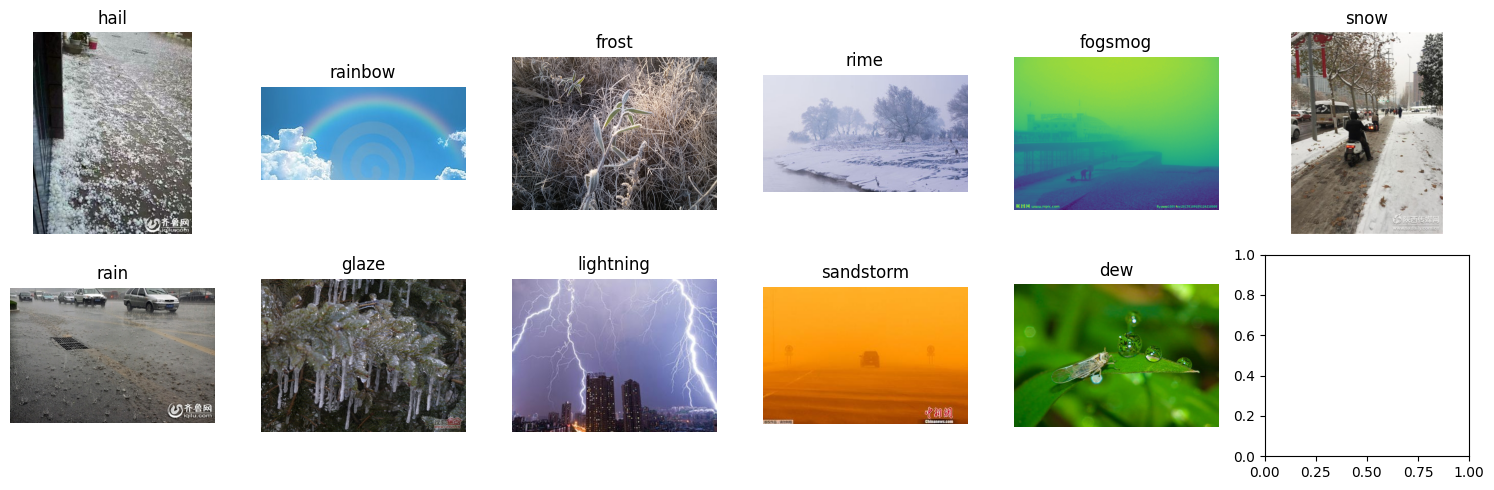

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image


nclass = len(categories)
nrow = 2
ncol = (nclass + 1) // nrow

# Create the subplot grid with nrow and ncol rows and columns
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 5))

for i, category in enumerate(categories):
    row_idx = i // ncol
    col_idx = i % ncol

    # Handle cases where nrow=1 results in a 1D axs array,
    current_ax = axs[col_idx] if nrow == 1 else axs[row_idx, col_idx]

    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    if image_files:
        random_image_file = random.choice(image_files)
        img_path = os.path.join(category_path, random_image_file)
        img = Image.open(img_path)
        current_ax.imshow(img)
        current_ax.set_title(category)
        current_ax.axis('off') # Hide axes ticks and labels

plt.tight_layout()
plt.show()

## Creating a Training and Test Datasets
This particular dataset has a single set of images.  Write code that will create two directories `train` and `test`, each with a sub-folder structure  with one set of images per class.  You should randomly place a fraction `split_ratio` of the images in the `train` folder, and the remaining in the `test` folder.

In [13]:
import shutil # Added for file copying
import random # Added for shuffling files

# Define the split ratio
split_ratio = 0.8 # 80% for training, 20% for testing

# Set the training and test directory paths
train_dir = os.path.normpath(os.path.join("/content/", "train"))
test_dir = os.path.normpath(os.path.join("/content/", "test"))

# Create train and test base directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lists to store counts for the DataFrame
train_counts = []
test_counts = []

# TODO:  Loop over each category and split the images into training and test sets
# in each category according to the split_ratio
for category in categories:
    category_src_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_src_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    random.shuffle(image_files) # Shuffle files for random split

    # Calculate split point
    split_point = int(len(image_files) * split_ratio)
    train_files = image_files[:split_point]
    test_files = image_files[split_point:]

    # Create category specific directories in train and test
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Copy files to training directory
    for f in train_files:
        shutil.copy(os.path.join(category_src_path, f), os.path.join(train_dir, category, f))

    # Copy files to test directory
    for f in test_files:
        shutil.copy(os.path.join(category_src_path, f), os.path.join(test_dir, category, f))

    # Store counts for this category
    train_counts.append(len(train_files))
    test_counts.append(len(test_files))


# TODO:  Count the number of images in each category for training and test sets
# and display the counts in a DataFrame

df_split_counts = pd.DataFrame({    'Category': categories,'Train Count': train_counts,'Test Count': test_counts})
display(df_split_counts)

print(f"\nTotal images in training set: {sum(train_counts)}")
print(f"Total images in test set: {sum(test_counts)}")

,Category,Train Count,Test Count
0,hail,472,119
1,rainbow,185,47
2,frost,380,95
3,rime,928,232
4,fogsmog,680,171
5,snow,496,125
6,rain,420,106
7,glaze,511,128
8,lightning,301,76
9,sandstorm,553,139



Total images in training set: 5484
Total images in test set: 1378


## Downloading the base model

Pytorch ha a number of excellent pre-trained models that we can use for fine tuning.    For this lab, to make the training easy, we will use a lightweight model called **MobileNetV2**.  MobileNetV2 is a CNN developed by Google that targeting mobile devices that are computationally limited. It uses an architecture with inverted residual blocks and linear bottlenecks to improve performance while keeping computational costs low. A nice summary of the model can be found in this [Medium post](https://medium.com/codex/a-summary-of-the-mobilenetv2-inverted-residuals-and-linear-bottlenecks-paper-e19b187cb78a).  We can download the model as follows.

First we download the key packages and set a `transform` needed for the MobileNetV2.

In [14]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Next, we create `DataLoader` classes to load the models.


In [16]:
# TODO:  Create the training and test datasets.  Use the `datasets.ImageFolder` class
# with the appropriate directory and transform.
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


# TODO:  Create the training and test dataloaders.  Use a batch size of 16.
#    train_loader = ...
#    test_loader = ...
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# TODO:  Print the number of classes.
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 11


Now we download the pre-trained model.

In [17]:
model = models.mobilenet_v2(pretrained=True)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 129MB/s]


The MobileNetV2 model has two main components:
- `model.features`
This is the **base model**, also known as the **backbone**. It contains the convolutional layers that extract features from the input image.
👉 In transfer learning, we typically freeze this part to retain the pretrained feature extractor.
- `model.classifier`
This is the **classifier head**. It takes the output from `model.features` and maps it to the final class predictions.
👉 We **replace and train** this part to adapt the model to our specific task (e.g., weather classification)


First, we can see all the layers with the following command.

In [18]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

To get some insight into the model:

* Loop over the layers in the model with `name, layer in model.features.named_children`
* For each layer, get the layer type with `layer_type = layer.__class__.__name__`
* Get the total number of parameters in the layers
    * You can loop over the parameters with `for p in layers.parameters`
    * Then count the number of paramters with `p.numel()`
* Print a `pandas.DataFrame` with the layer `name`, `layer_type`, and number of elements.
* Also, print the total number of paramters.

You should see that the model has about 2.2M parameters.

In [19]:
# TODO:  Get the layer names, types, and number of parameters in each layer of
# model.features
layer_data = []
for name, layer in model.features.named_children():
    num_params = sum(p.numel() for p in layer.parameters())
    layer_datai = {'name': name, 'layer_type': layer.__class__.__name__, 'num_param': num_params}
    layer_data.append(layer_datai)


# TODO:  Create a pandas DataFrame and print the layer data
df_layers = pd.DataFrame(layer_data)
display(df_layers)


# TODO:  Print the total number of parameters
total_params_features = sum(p.numel() for p in model.features.parameters())
print(f"Total parameters in model.features: {total_params_features}")

,name,layer_type,num_param
0,0,Conv2dNormActivation,928
1,1,InvertedResidual,896
2,2,InvertedResidual,5136
3,3,InvertedResidual,8832
4,4,InvertedResidual,10000
5,5,InvertedResidual,14848
6,6,InvertedResidual,14848
7,7,InvertedResidual,21056
8,8,InvertedResidual,54272
9,9,InvertedResidual,54272


Total parameters in model.features: 2223872


We will next the number of features from the final layer of the features model.  This value will be the number of inputs to the classifier head.

In [20]:
# TODO:  Get the number of outputs of the final layer of model.features
#    num_features = ...
num_features = model.features[-1][0].out_channels
print(f"Number of features from the final layer of model.features: {num_features}")

Number of features from the final layer of model.features: 1280


Now, let's look at the classifier.  This is a simple model with two layers:
* A dropout layer
* A fully connected layer with 1000 output features for a 1000-way softmax (recall the original ImageNet has 1000 classes).

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

For fine-tuning, we will replace the classifer head with a small MLP:
*  A `nn.Dropout` layer with 0.2 dropout
*  A `nn.Linear` layer taking the `num_features` input to the `num_hidden` output
* A ReLU activation
* A final linear layer with the one output for each class.

In [22]:
num_hidden = 100

# TODO:  Replace the classifier head
#  model.classifier = nn.Sequential(...)
model.classifier = nn.Sequential(    nn.Dropout(0.2),    nn.Linear(num_features, num_hidden),nn.ReLU(inplace=True),    nn.Linear(num_hidden, num_classes))

Next, we **freeze** the parameters in all the `model.features` layers, so we only retrain the final layer.  This will make the training much faster.  You can loop over `model.features.parameters()` and set `param.requires_grad = False`.

In [23]:
# TODO:  Freeze all the parameters in model.features
for param in model.features.parameters():
    param.requires_grad = False

To confirm we set everything correctly, loop over `model.parameters()` and find the total number of parameters that are trainable and total number that are fixed.  You should get that only about 129,000 are trainable.

In [24]:
# TODO:  Print the total number of trainable and fixed parameters
#   trainable = ...
#   fixed = ...

trainable = 0
fixed = 0

for name, param in model.named_parameters():
    if param.requires_grad:
        trainable += param.numel()
    else:
        fixed += param.numel()

print(f"Total trainable parameters: {trainable}")
print(f"Total fixed parameters: {fixed}")

Total trainable parameters: 129211
Total fixed parameters: 2223872


## Loading the model to a GPU
For training image models, it greatly helps to use a GPU.  
* Use the `torch.cuda.is_available()` to see if a GPU is available.  
* If so, print the number of GPUs with `torch.cuda.device_count()`
* Also, print the GPU name with `torch.cudu.get_device_name` and `torch.cuda.get_current_device()`.


In [25]:
# TODO:  See if there is a GPU and what type of GPU

if torch.cuda.is_available():
    print("GPU is available")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}") # Assuming device 0 for simplicity
    print(f"Current GPU Device: {torch.cuda.current_device()}")
else:
    print("GPU is not available. Using CPU.")

GPU is available
Number of GPUs: 1
GPU Name: NVIDIA L4
Current GPU Device: 0


Finally, we move the model to the GPU with the following command.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



## Training the model
We are now ready to train our model.  First we select the loss function criterion and optimizer.

In [27]:
# TODO:  Set loss function and optimizer
#   criterion = ...  (use cross entropy loss)
#   optimizer = ...  (use Adam with a lr=1e-4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

You can now train the model by completing the following code.  With a T4 GPU, each epoch should complete in a few minutes.  You should be able to get about 85% accuracy.  You can higher accuracy with a larger model, larger classifier head, and more time.  But, I want you to just understand the basic ideas.



In [28]:
from tqdm import tqdm

nepochs = 5
for epoch in range(nepochs):  # Adjust epochs as needed
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    for images, labels in loop:

        # TODO:  Move the images to the GPU
        #   images = images.to(...)
        #   labels = labels.to(...)
        images = images.to(device)
        labels = labels.to(device)


        # TODO:  Perform the back-prop on the data
        #    optimizer.zero_grad()
        #    outputs = ...
        #    loss = ...
        #    ...
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # Update the running loss and progress bar
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {running_loss:.4f}")

    # Evaluation after each epoch
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      loop = tqdm(test_loader, desc="Evaluating", leave=True)

      for images, labels in loop:

          # TODO:  Move the images and labels to the GPU
          #   images = images.to(...)
          #   labels = labels.to(...)
          images = images.to(device)
          labels = labels.to(device)


          # TODO:  Update the total number of correct and total number of images
          #    correct += ...
          #    total += ...
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


          # Update postfix with current accuracy
          accuracy = 100 * correct / total
          loop.set_postfix({'Accuracy': f'{accuracy:.2f}%'})

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Test Accuracy: {accuracy:.2f}%\n")

Epoch 1: 100%|██████████| 343/343 [00:35<00:00,  9.72it/s, loss=0.911]


Epoch 1, Training Loss: 532.6626


Evaluating: 100%|██████████| 87/87 [00:08<00:00, 10.39it/s, Accuracy=80.12%]


Epoch 1, Test Accuracy: 80.12%



Epoch 2: 100%|██████████| 343/343 [00:33<00:00, 10.13it/s, loss=0.729]


Epoch 2, Training Loss: 286.4817


Evaluating: 100%|██████████| 87/87 [00:08<00:00, 10.40it/s, Accuracy=83.45%]


Epoch 2, Test Accuracy: 83.45%



Epoch 3: 100%|██████████| 343/343 [00:33<00:00, 10.19it/s, loss=0.371]


Epoch 3, Training Loss: 223.2943


Evaluating: 100%|██████████| 87/87 [00:08<00:00, 10.42it/s, Accuracy=84.33%]


Epoch 3, Test Accuracy: 84.33%



Epoch 4: 100%|██████████| 343/343 [00:33<00:00, 10.16it/s, loss=0.335]


Epoch 4, Training Loss: 192.4683


Evaluating: 100%|██████████| 87/87 [00:08<00:00, 10.38it/s, Accuracy=84.69%]


Epoch 4, Test Accuracy: 84.69%



Epoch 5: 100%|██████████| 343/343 [00:33<00:00, 10.14it/s, loss=0.3]


Epoch 5, Training Loss: 176.2815


Evaluating: 100%|██████████| 87/87 [00:08<00:00, 10.46it/s, Accuracy=86.21%]

Epoch 5, Test Accuracy: 86.21%



In [29]:
# Save the model
torch.save(model.state_dict(), "mobilenetv2_weights.pth")


## Evaluating the model

Let's conclude by evaluating the model.  First we reset the model architecture and then load the parameters.

In [30]:
# Set parameters
num_hidden = 100

# Load base model
model = models.mobilenet_v2()

# TODO:  Rebuild the classifier head
#  model.classifier = nn.Sequential(...)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, num_hidden),
    nn.ReLU(inplace=True),
    nn.Linear(num_hidden, num_classes)
)


# Load weights
model.load_state_dict(torch.load("mobilenetv2_weights.pth"))
model.to(device)
model.eval();

Now run the model and create a confusion matrix.
* Evaluate the model on the `test_loader` dataset
* Add a `tqdm` loop to display the progress as it evaluates the data
* Create a confusion matrix and display the confusion matrix with `ConfusionMatrixDisplay` function.

Evaluating: 100%|██████████| 87/87 [00:08<00:00, 10.31it/s, Accuracy=86.21%]


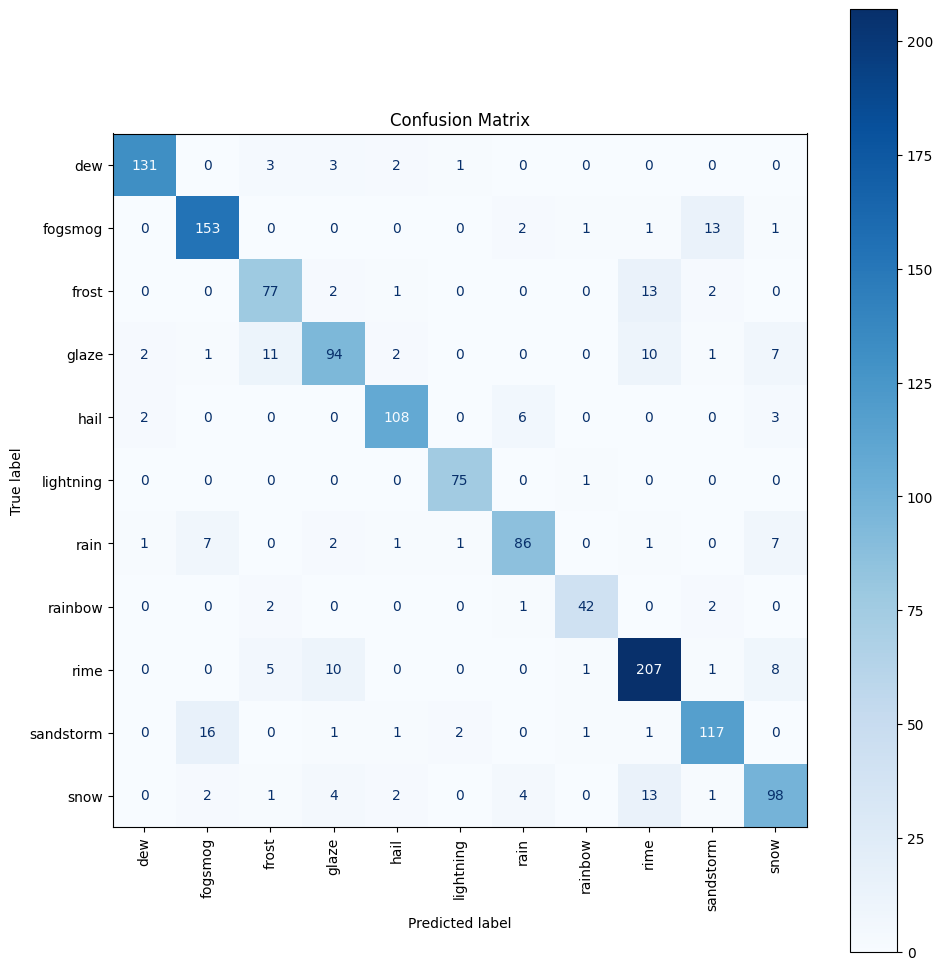

In [31]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# TODO:  Evaluate the model on the test_loader dataset.
#
#  with torch.no_grad():
#      for images, labels in test_loader:
#        ...
#
#  cm  = confusion_matrix(...)

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating", leave=True)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update  with current accuracy
        accuracy = 100 * correct / total
        loop.set_postfix({'Accuracy': f'{accuracy:.2f}%'})

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Finally, print the top `k=10` confusion matrix pairs with the highest percent errors.  Your final list should be something like:
~~~
Top 10 pairs with the highest error:
      snow ->      glaze:  error=0.08750
     frost ->       snow:  error=0.07586
     glaze ->       hail:  error=0.07563
      rain ->  lightning:  error=0.07512
      hail ->      glaze:  error=0.06250
     glaze ->       snow:  error=0.05517
     frost ->  sandstorm:  error=0.05303
      snow ->      frost:  error=0.05128
 sandstorm ->      frost:  error=0.04487
      hail ->       snow:  error=0.04138
~~~




In [32]:
# TODO
# Print the name of the category pair with the highest error.

k = 10
class_names = train_dataset.classes

error_pairs = []
for i in range(len(class_names)):
    true_class_name = class_names[i]
    total_true_samples = cm[i, :].sum()
    if total_true_samples == 0:
        continue

    for j in range(len(class_names)):
        if i == j:
            continue

        misclassified_count = cm[i, j]
        if misclassified_count > 0:
            error_percentage = (misclassified_count / total_true_samples) * 100
            predicted_class_name = class_names[j]
            error_pairs.append((error_percentage, true_class_name, predicted_class_name))

error_pairs.sort(key=lambda x: x[0], reverse=True)

print(f"Top {k} pairs with the highest error:")
for error_percent, true_class, predicted_class in error_pairs[:k]:
    print(f"{true_class:>10} -> {predicted_class:>10}: error={error_percent:.5f}")

Top 10 pairs with the highest error:
     frost ->       rime: error=13.68421
 sandstorm ->    fogsmog: error=11.51079
      snow ->       rime: error=10.40000
     glaze ->      frost: error=8.59375
     glaze ->       rime: error=7.81250
   fogsmog ->  sandstorm: error=7.60234
      rain ->    fogsmog: error=6.60377
      rain ->       snow: error=6.60377
     glaze ->       snow: error=5.46875
      hail ->       rain: error=5.04202
